# Adventures with Autodiff

------

#### Prepared for the CEF Workshop (June 2024)
#### John Stachurski

------

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

Checking for a GPU:

In [2]:
!nvidia-smi

/home/john/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Tue Jun 18 19:02:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A2000 8GB Lap...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0              N/A /  35W |      7MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## What is automatic differentiation?

Autodiff is a technique for calculating derivatives on a computer.

### Autodiff is not finite differences

The derivative of $f(x) = \exp(2x)$ is

$$
    f'(x) = 2 \exp(2x)
$$



A computer that doesn't know how to take derivatives might approximate this with the finite difference ratio

$$
    (Df)(x) := \frac{f(x+h) - f(x)}{h}
$$

where $h$ is a small positive number.

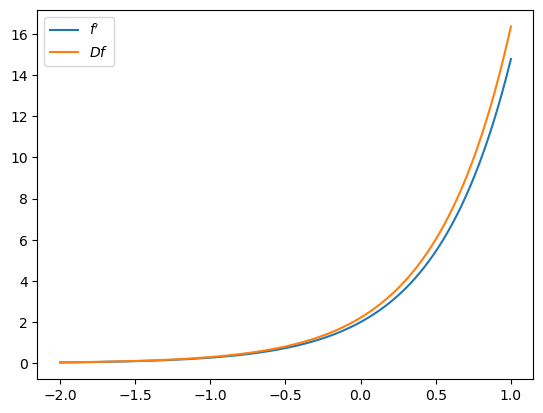

In [3]:
def f(x):
    "Original function."
    return np.exp(2 * x)

def f_prime(x):
    "True derivative."
    return 2 * np.exp(2 * x)

def Df(x, h=0.1):
    "Approximate derivative (finite difference)."
    return (f(x + h) - f(x))/h

x_grid = np.linspace(-2, 1, 200)
fig, ax = plt.subplots()
ax.plot(x_grid, f_prime(x_grid), label="$f'$")
ax.plot(x_grid, Df(x_grid), label="$Df$")
ax.legend()
plt.show()

This kind of numerical derivative is often inaccurate and unstable.

One reason is that 

$$
    \frac{f(x+h) - f(x)}{h} \approx \frac{0}{0}
$$

Small numbers in the numerator and denominator causes rounding errors.

The situation is exponentially worse in high dimensions / with higher order derivatives

### Autodiff is not symbolic calculus

Symbolic calculus tries to use rules for differentiation to produce a single
closed-form expression representing a derivative.

In [4]:
from sympy import symbols, diff

m, a, b, x = symbols('m a b x')
f_x = (a*x + b)**m
f_x.diff((x, 6))  # 6-th order derivative

a**6*m*(a*x + b)**m*(m**5 - 15*m**4 + 85*m**3 - 225*m**2 + 274*m - 120)/(a*x + b)**6

Symbolic calculus is not well suited to high performance
computing.

One disadvantage is that symbolic calculus cannot differentiate through control flow.

Also, using symbolic calculus might involve redundant calculations.

For example, consider

$$
    (f g h)'
    = (f' g + g' f) h + (f g) h'
$$

If we evaluate at $x$, then we evalute $f(x)$ and $g(x)$ twice each.

Also, computing $f'(x)$ and $f(x)$ might involve similar terms (e.g., $(f(x) = \exp(2x)' \implies f'(x) = 2f(x)$) but this is not exploited in symbolic algebra.

### Autodiff 

Autodiff produces functions that evaluates derivatives at numerical values
passed in by the calling code, rather than producing a single symbolic
expression representing the entire derivative.

Derivatives are constructed by breaking calculations into component parts via the chain rule.

The chain rule is applied until the point where the terms reduce to primitive functions that the program knows how to differentiate exactly (addition, subtraction, exponentiation, sine and cosine, etc.)

## Some experiments

Let's start with some real-valued functions on $\mathbb R$.

### A differentiable function

Let's test JAX's auto diff with a relatively simple function.

In [5]:
def f(x):
    return jnp.sin(x) - 2 * jnp.cos(3 * x) * jnp.exp(- x**2)

We use `grad` to compute the gradient of a real-valued function:

In [6]:
f_prime = jax.grad(f)

Let's plot the result:

In [7]:
x_grid = jnp.linspace(-5, 5, 100)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


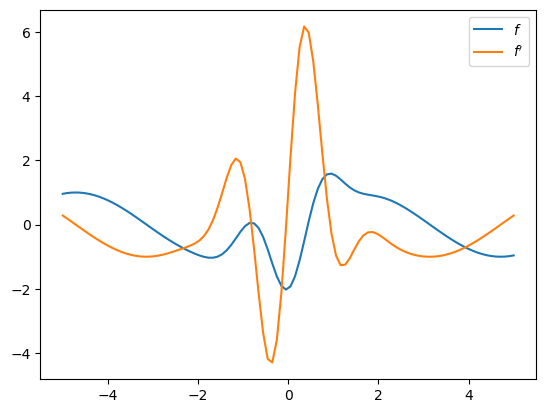

In [8]:
fig, ax = plt.subplots()
ax.plot(x_grid, [f(x) for x in x_grid], label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend()
plt.show()

### Absolute value function

What happens if the function is not differentiable?

In [9]:
def f(x):
    return jnp.abs(x)

In [10]:
f_prime = jax.grad(f)

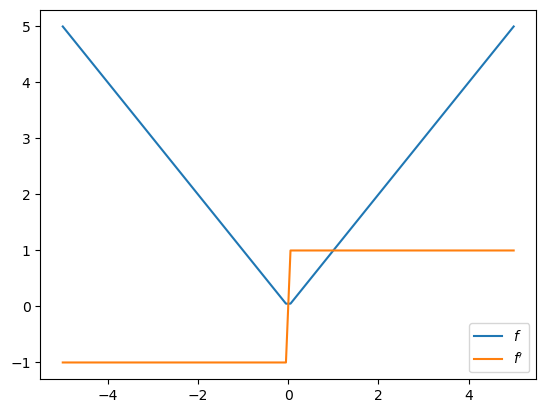

In [11]:
fig, ax = plt.subplots()
ax.plot(x_grid, [f(x) for x in x_grid], label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend()
plt.show()

At the nondifferentiable point $0$, `jax.grad` returns the right derivative:

In [12]:
f_prime(0.0)

Array(1., dtype=float32, weak_type=True)

### Differentiating through control flow

Let's try differentiating through some loops and conditions.

In [13]:
def f(x):
    def f1(x):
        for i in range(2):
            x *= 0.2 * x
        return x
    def f2(x):
        x = sum((x**i + i) for i in range(3))
        return x
    y = f1(x) if x < 0 else f2(x)
    return y

In [14]:
f_prime = jax.grad(f)

In [15]:
x_grid = jnp.linspace(-5, 5, 100)

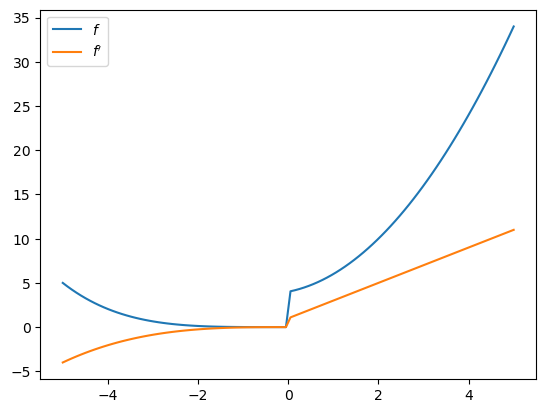

In [16]:
fig, ax = plt.subplots()
ax.plot(x_grid, [f(x) for x in x_grid], label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend()
plt.show()

### Differentiating through a linear interpolation

We can differentiate through linear interpolation, even though the function is not smooth:

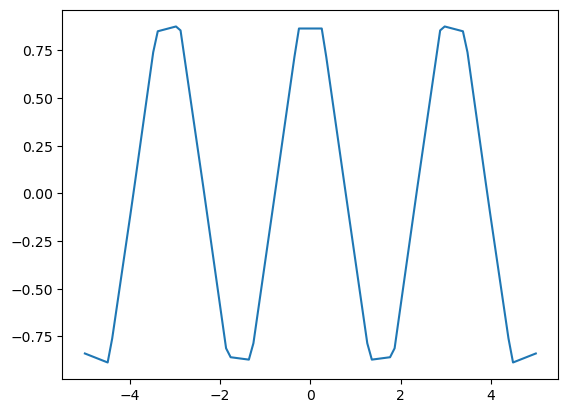

In [17]:
n = 20
xp = jnp.linspace(-5, 5, n)
yp = jnp.cos(2 * xp)

fig, ax = plt.subplots()
ax.plot(x_grid, jnp.interp(x_grid, xp, yp))
plt.show()

In [18]:
f_prime = jax.grad(jnp.interp)

In [19]:
f_prime_vec = jax.vmap(f_prime, in_axes=(0, None, None))

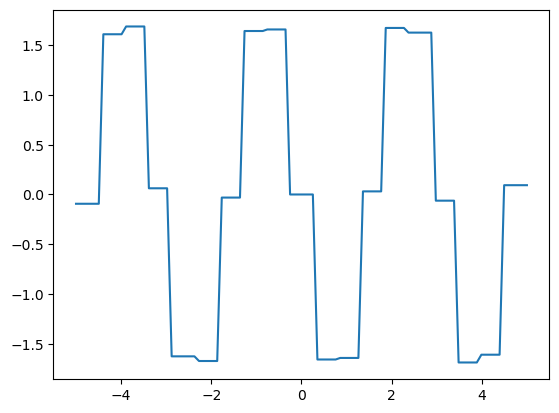

In [20]:
fig, ax = plt.subplots()
ax.plot(x_grid, f_prime_vec(x_grid, xp, yp))
plt.show()

## Gradient Descent

Let's try implementing gradient descent.

As a simple application, we'll use gradient descent to solve for the OLS parameter estimates in simple linear regression.

### A function for gradient descent

Here's an implementation of gradient descent.

In [31]:
def grad_descent(f,       # Function to be minimized
                 args,    # Extra arguments to the function
                 x0,      # Initial condition
                 λ=0.1,   # Initial learning rate
                 tol=1e-5, 
                 max_iter=1_000):
    """
    Minimize the function f via gradient descent, starting from guess x0.

    The learning rate is computed according to the Barzilai-Borwein method.
    
    """
    
    f_grad = jax.grad(f)
    x = jnp.array(x0)
    df = f_grad(x, args)
    ϵ = tol + 1
    i = 0
    while ϵ > tol and i < max_iter:
        new_x = x - λ * df
        new_df = f_grad(new_x, args)
        Δx = new_x - x
        Δdf = new_df - df
        λ = jnp.abs(Δx @ Δdf) / (Δdf @ Δdf)
        ϵ = jnp.max(jnp.abs(Δx))
        x, df = new_x, new_df
        i += 1
        
    return x
    

### Simulated data

We're going to test our gradient descent function my minimizing a sum of least squares in a regression problem.

Let's generate some simulated data:

In [32]:
n = 100
key = jax.random.PRNGKey(1234)
x = jax.random.uniform(key, (n,))

α, β, σ = 0.5, 1.0, 0.1  # Set the true intercept and slope.
key, subkey = jax.random.split(key)
ϵ = jax.random.normal(subkey, (n,))

y = α * x + β + σ * ϵ

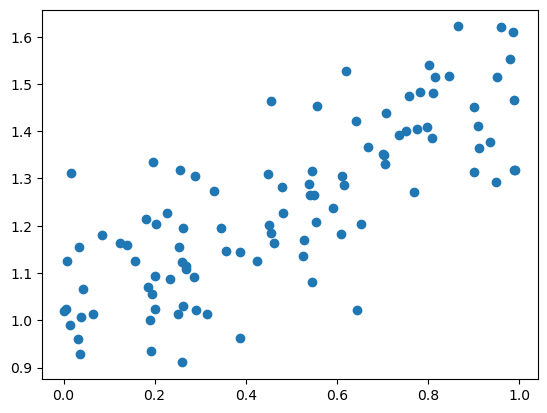

In [33]:
fig, ax = plt.subplots()
ax.scatter(x, y)
plt.show()

Let's start by calculating the estimated slope and intercept using closed form solutions.

In [34]:
mx = x.mean()
my = y.mean()
α_hat = jnp.sum((x - mx) * (y - my)) / jnp.sum((x - mx)**2)
β_hat = my - α_hat * mx

In [35]:
α_hat, β_hat

(Array(0.45994443, dtype=float32), Array(1.0219053, dtype=float32))

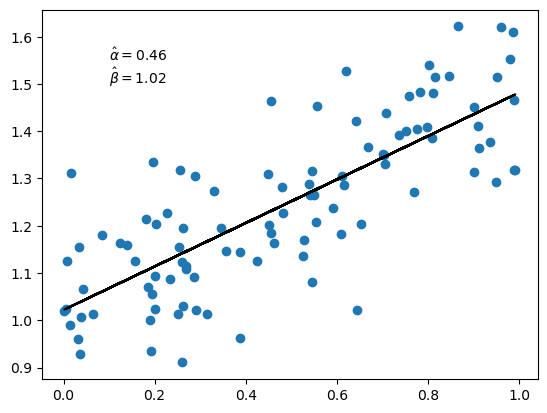

In [36]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x, α_hat * x + β_hat, 'k-')
ax.text(0.1, 1.55, rf'$\hat \alpha = {α_hat:.3}$')
ax.text(0.1, 1.50, rf'$\hat \beta = {β_hat:.3}$')
plt.show()

### Minimizing squared loss by gradient descent

Let's see if we can get the same values with our gradient descent function.

First we set up the least squares loss function.

In [37]:
@jax.jit
def loss(params, data):
    a, b = params
    x, y = data
    return jnp.sum((y - a * x - b)**2)

Now we minimize it:

In [38]:
p0 = jnp.zeros(2)  # Initial guess for α, β
data = x, y
α_hat, β_hat = grad_descent(loss, data, p0)

Let's plot the results.

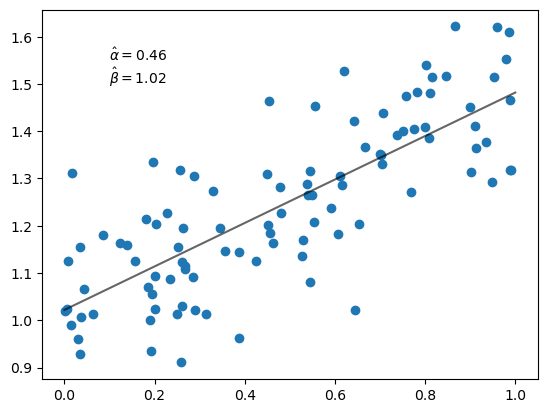

In [39]:
fig, ax = plt.subplots()
x_grid = jnp.linspace(0, 1, 100)
ax.scatter(x, y)
ax.plot(x_grid, α_hat * x_grid + β_hat, 'k-', alpha=0.6)
ax.text(0.1, 1.55, rf'$\hat \alpha = {α_hat:.3}$')
ax.text(0.1, 1.50, rf'$\hat \beta = {β_hat:.3}$')
plt.show()

Notice that we get the same estimates as we did from the closed form solutions.

### Adding a squared term

Now let's try fitting a second order polynomial.

Here's our new loss function.

In [40]:
@jax.jit
def loss(params, data):
    a, b, c = params
    x, y = data
    return jnp.sum((y - a * x**2 - b * x - c)**2)

Now we're minimizing in three dimensions.

Let's try it.

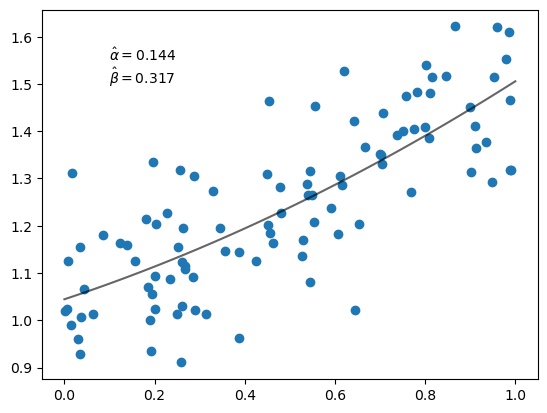

In [41]:
p0 = jnp.zeros(3)
α_hat, β_hat, γ_hat = grad_descent(loss, data, p0)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x_grid, α_hat * x_grid**2 + β_hat * x_grid + γ_hat, 'k-', alpha=0.6)
ax.text(0.1, 1.55, rf'$\hat \alpha = {α_hat:.3}$')
ax.text(0.1, 1.50, rf'$\hat \beta = {β_hat:.3}$')
plt.show()

## Exercise

The function `jnp.polyval` evaluates polynomials.  

For example, if `len(p)` is 3, then `jnp.polyval(p, x)`  returns

$$
    f(p, x) := p_0 x^2 + p_1 x + p_2
$$

Use this function for polynomial regression.

The (empirical) loss becomes

$$
    \ell(p, x, y) 
    = \sum_{i=1}^n (y_i - f(p, x_i))^2
$$

Set $k=4$ and set the initial guess of `params` to `jnp.zeros(k)`.

Use gradient descent to find the array `params` that minimizes the loss
function and plot the result (following the examples above).

In [42]:
for i in range(18):
    print("Solution below 🦀")

Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀
Solution below 🦀


In [43]:
def loss(params, data):
    x, y = data
    return jnp.sum((y - jnp.polyval(params, x))**2)

Estimated parameter vector:
[-0.75860673  1.2702719  -0.11843722  1.0770503 ]





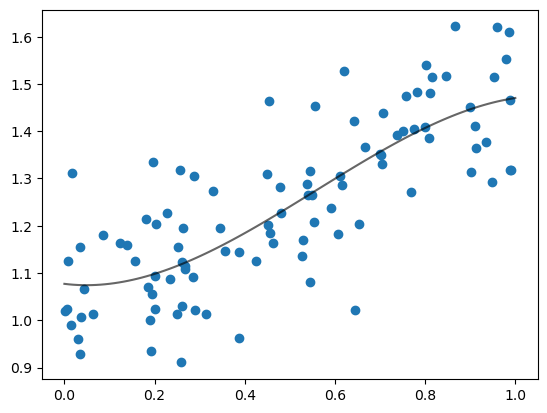

In [44]:
k = 4
p0 = jnp.zeros(k)
p_hat = grad_descent(loss, data, p0)
print('Estimated parameter vector:')
print(p_hat)
print('\n\n')

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x_grid, jnp.polyval(p_hat, x_grid), 'k-', alpha=0.6)
plt.show()